In [2]:
import cv2
import sys
import torch

In [10]:
import matplotlib.pyplot as plt


In [3]:
from util.load_models import load_netArc, load_face_swap_model, load_insightface_model

/data1/tides/new/miniconda3/envs/faceSwap/lib/python3.8/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.24 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
from options.test_options import TestOptions

sys.argv = sys.argv[:1]

opt = TestOptions().parse() 

opt.use_mask = True
opt.name = 'people'
opt.Arc_path = './checkpoints/arcface_model/arcface_checkpoint.tar'
opt.crop_size = 224

------------ Options -------------
Arc_path: arcface_model/arcface_checkpoint.tar
aspect_ratio: 1.0
batchSize: 8
checkpoints_dir: ./checkpoints
cluster_path: features_clustered_010.npy
crop_size: 512
data_type: 32
dataroot: ./datasets/cityscapes/
display_winsize: 512
engine: None
export_onnx: None
feat_num: 3
fineSize: 512
fp16: False
gpu_ids: [0]
how_many: 50
id_thres: 0.03
image_size: 224
input_nc: 3
instance_feat: False
isTrain: False
label_feat: False
label_nc: 0
latent_size: 512
loadSize: 1024
load_features: False
local_rank: 0
max_dataset_size: inf
multisepcific_dir: ./demo_file/multispecific
nThreads: 2
n_blocks_global: 6
n_blocks_local: 3
n_clusters: 10
n_downsample_E: 4
n_downsample_global: 3
n_local_enhancers: 1
name: people
nef: 16
netG: global
ngf: 64
niter_fix_global: 0
no_flip: False
no_instance: False
no_simswaplogo: False
norm: batch
norm_G: spectralspadesyncbatch3x3
ntest: inf
onnx: None
output_nc: 3
output_path: ./output/
phase: test
pic_a_path: G:/swap_data/ID/elon-m

In [6]:
netArc = load_netArc(opt.Arc_path, device)
face_swap_model = load_face_swap_model(device, netArc, opt)
detect_model = load_insightface_model(device)

/home/tides/SimSwap/util/load_models.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  netArc = torch.load(Arc_path, map_location=torch.device("cpu"))
/home/tides/SimSwap

Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}, 'CUDAExecutionProvider': {'sdpa_kernel': '0', 'use_tf32': '1', 'prefer_nhwc': '0', 'tunable_op_max_tuning_duration_ms': '0', 'enable_skip_layer_norm_strict_mode': '0', 'tunable_op_tuning_enable': '0', 'tunable_op_enable': '0', 'use_ep_level_unified_stream': '0', 'device_id': '0', 'has_user_compute_stream': '0', 'gpu_external_empty_cache': '0', 'cudnn_conv_algo_search': 'EXHAUSTIVE', 'cudnn_conv1d_pad_to_nc1d': '0', 'gpu_mem_limit': '18446744073709551615', 'gpu_external_alloc': '0', 'gpu_external_free': '0', 'arena_extend_strategy': 'kNextPowerOfTwo', 'do_copy_in_default_stream': '1', 'enable_cuda_graph': '0', 'user_compute_stream': '0', 'cudnn_conv_use_max_workspace': '1'}}
find model: ./checkpoints/models/antelopev2/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CPUExecutionProvi

In [7]:
source_image_path = 'demo_file/source_image/Iron_man.jpg'
target_video_path = 'demo_file/target_video/jirou_anni.mp4'
result_video_path = 'demo_file/result'

## Source图像处理

In [8]:
source_image = cv2.imread(source_image_path)

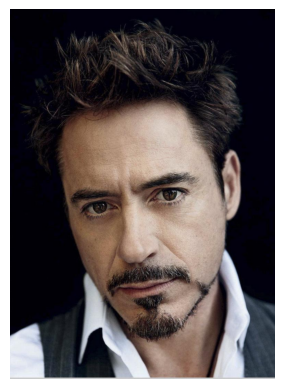

In [11]:
source_image_rgb = cv2.cvtColor(source_image, cv2.COLOR_BGR2RGB)

# 显示图像
plt.imshow(source_image_rgb)
plt.axis('off')  # 不显示坐标轴
plt.show()

In [12]:
from util.face_process import crop_and_align_face
from util.data_process import process_latent_id

source_crop_align_image, source_M = crop_and_align_face(detect_model, source_image, opt.crop_size)
latend_id = process_latent_id(source_crop_align_image, netArc, device)

/data1/tides/new/miniconda3/envs/faceSwap/lib/python3.8/site-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


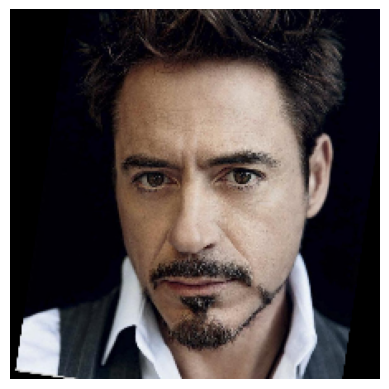

In [13]:
source_crop_align_image_rgb = cv2.cvtColor(source_crop_align_image, cv2.COLOR_BGR2RGB)

# 显示图像
plt.imshow(source_crop_align_image_rgb)
plt.axis('off')  
plt.show()

## Target视频处理

In [ ]:
target_video = cv2.VideoCapture(target_video_path)
target_video.set(cv2.CAP_PROP_POS_FRAMES, 150)

ret, frame = target_video.read()

In [ ]:
target_crop_align_image, target_M = crop_and_align_face(detect_model, frame, opt.crop_size)

In [ ]:
from util.data_process import process_image_tensor

In [ ]:
target_crop_align_tensor = process_image_tensor(target_crop_align_image)

## 人脸交换

In [ ]:
swap_result = face_swap_model(None, target_crop_align_tensor, latend_id, None, True)

## 图像重建

In [6]:
from torchinfo import summary

In [8]:
# 创建输入张量
x1 = torch.randn(1, 512)  # 第一个输入 (1, 512)
x2 = torch.randn(1, 3, 224, 224)  # 第二个输入 (1, 3, 224, 224)
latent_id = torch.randn(1, 512)  # 第三个输入 (1, 512) (根据实际情况修改形状)
latent_att = torch.randn(1, 512)  # 第四个输入 (1, 512) (根据实际情况修改形状)

# 提供所有输入
summary(face_swap_model, input_size=[(1, 512), (1, 3, 224, 224), (1, 512), (1, 512)])

Layer (type:depth-idx)                             Output Shape              Param #
fsModel                                            [1, 3, 224, 224]          52,193,215
├─Generator_Adain_Upsample: 1-1                    --                        --
│    └─Sequential: 2-1                             [1, 64, 224, 224]         --
│    │    └─ReflectionPad2d: 3-1                   [1, 3, 230, 230]          --
│    │    └─Conv2d: 3-2                            [1, 64, 224, 224]         9,472
│    │    └─BatchNorm2d: 3-3                       [1, 64, 224, 224]         128
│    └─Sequential: 2-31                            --                        (recursive)
│    │    └─ReLU: 3-4                              [1, 64, 224, 224]         --
│    └─Sequential: 2-3                             [1, 128, 112, 112]        --
│    │    └─Conv2d: 3-5                            [1, 128, 112, 112]        73,856
│    │    └─BatchNorm2d: 3-6                       [1, 128, 112, 112]        256
│    └─Se

In [9]:
torch.save(face_swap_model.state_dict(), 'face_swap_model.pth')


In [6]:
from torch.utils.tensorboard import SummaryWriter

In [7]:
writer = SummaryWriter(log_dir='./logs')

In [18]:
# 创建输入张量
x1 = torch.randn(1, 512).to("cuda")  # 第一个输入 (1, 512)
x2 = torch.randn(1, 3, 224, 224).to("cuda")  
latent_att = torch.randn(1, 512).to("cuda")  # 第三个输入 (1, 512)

In [19]:

# 导出模型为 ONNX 文件
torch.onnx.export(
    face_swap_model,                        # 模型
    (x1, x2, latent_att),                   # 模型的 3 个输入
    "face_swap_model.onnx",                 # 导出文件名
    export_params=True,                     # 是否存储模型的参数
    opset_version=11,                       # ONNX opset 版本
    input_names=["x1", "x2", "latent_att"], # 定义输入名称
    output_names=["output"],                # 定义输出名称
    dynamic_axes={                          # 动态轴（可选）
        "x1": {0: "batch_size"}, 
        "x2": {0: "batch_size"},
        "latent_att": {0: "batch_size"},
        "output": {0: "batch_size"}
    }
)


/data1/tides/new/miniconda3/envs/faceSwap/lib/python3.8/site-packages/torch/onnx/_internal/jit_utils.py:314: UserWarning: Constant folding - Only steps=1 can be constant folded for opset >= 10 onnx::Slice op. Constant folding not applied. (Triggered internally at ../torch/csrc/jit/passes/onnx/constant_fold.cpp:179.)
  _C._jit_pass_onnx_node_shape_type_inference(node, params_dict, opset_version)
/data1/tides/new/miniconda3/envs/faceSwap/lib/python3.8/site-packages/torch/onnx/utils.py:739: UserWarning: Constant folding - Only steps=1 can be constant folded for opset >= 10 onnx::Slice op. Constant folding not applied. (Triggered internally at ../torch/csrc/jit/passes/onnx/constant_fold.cpp:179.)
  _C._jit_pass_onnx_graph_shape_type_inference(
/data1/tides/new/miniconda3/envs/faceSwap/lib/python3.8/site-packages/torch/onnx/utils.py:1244: UserWarning: Constant folding - Only steps=1 can be constant folded for opset >= 10 onnx::Slice op. Constant folding not applied. (Triggered internally at